###Autonomous Activity: Dimensionality Reduction on Embryo Development Timelapse
##Objectives:

Explore, visualize, and preprocess multi-frame .tif images.

Test and compare different data normalization strategies (e.g., [0,1] scaling vs StandardScaler).

Use PCA, SVD, t-SNE, UMAP, and Autoencoders to extract and visualize developmental trajectories.

Identify biological differences in developmental dynamics between embryo types.

Reflect on the advantages, limitations, and behaviors of each technique.

##Load and Explore the Dataset

Each .tif file contains ~450 grayscale frames. Your first task is to:

Load the 3 .tif files using tifffile.imread.

Normalize each image stack using two strategies:

[0, 1] Min-Max normalization

Standardization using StandardScaler

Plot a few representative frames across time for each embryo.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(450, 200, 200)
Original Embryos:


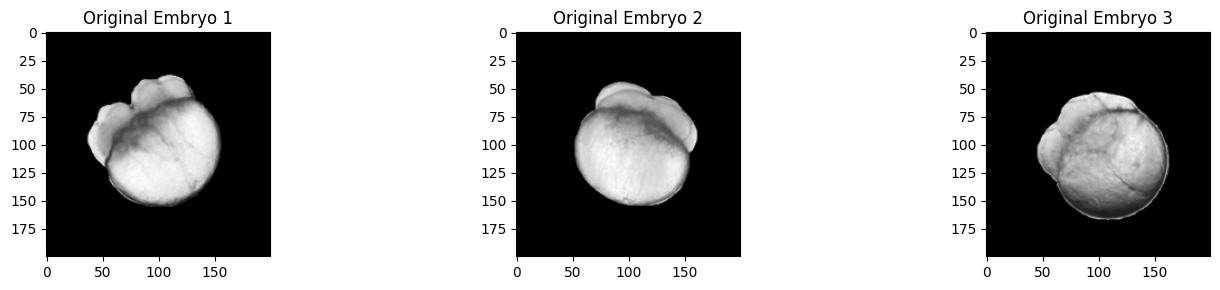


Min-Max Normalized Embryos:


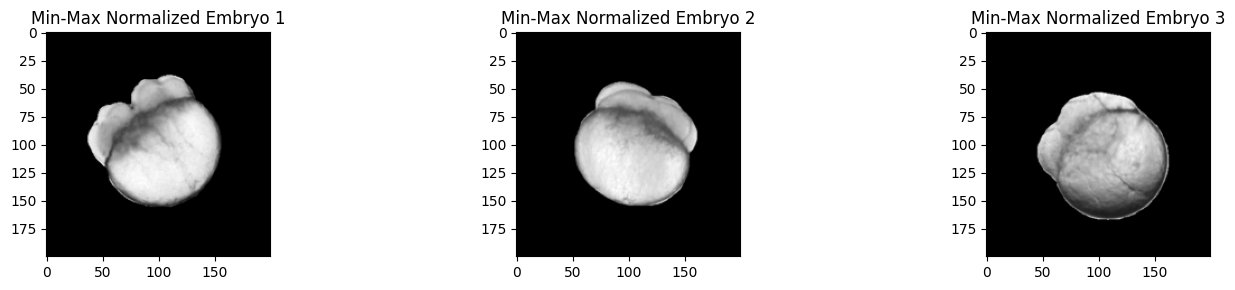


Standardized Embryos:


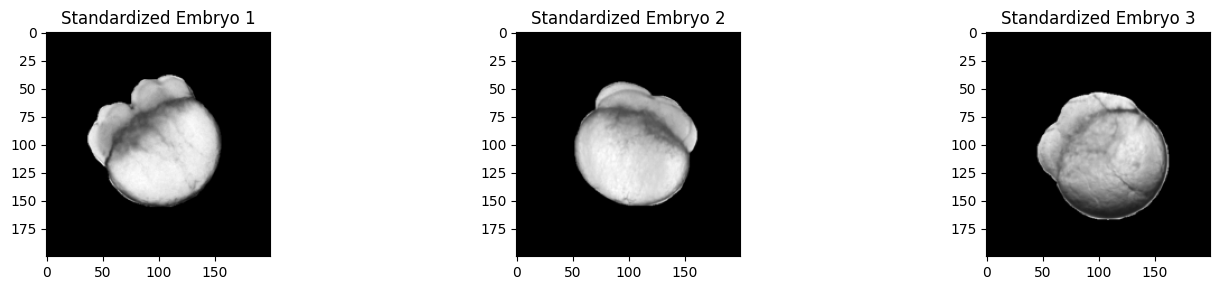

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tifffile
import os
from google.colab import drive
from google.colab import files


# Load the .tif files
# Replace with actual file paths
drive.mount('/content/drive')

file_paths = [
    '/content/drive/MyDrive/DS_ML_MFFF/data_small_zfish/Control.tif',
    '/content/drive/MyDrive/DS_ML_MFFF/data_small_zfish/Mutatnt1.tif',
    '/content/drive/MyDrive/DS_ML_MFFF/data_small_zfish/Mutatnt2.tif'
]

embryos = [tifffile.imread(fp) for fp in file_paths]
print (embryos[0].shape)


# Normalize each image stack
normalized_minmax = []
normalized_standard = []

for embryo in embryos:
    # Ensure float
    emb = embryo.astype('float32', copy=False)

    # Treat ALL pixels in the stack as a single feature for scaling
    flat = emb.reshape(-1, 1)  # (T*H*W, 1)

    # Min-Max to [0, 1] across the whole stack
    mm = MinMaxScaler()
    mm_flat = mm.fit_transform(flat)
    normalized_minmax.append(mm_flat.reshape(emb.shape))

    # Standardization (z-score) across the whole stack
    ss = StandardScaler()
    ss_flat = ss.fit_transform(flat)
    normalized_standard.append(ss_flat.reshape(emb.shape))

# Plot representative frames
def plot_frames(embryo_list, title_prefix):
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for i, embryo in enumerate(embryo_list):
      # Plot the first frame
        axes[i].imshow(embryo[0], cmap='gray')
        axes[i].set_title(f'{title_prefix} Embryo {i+1}')
        axes[i].axis('on')
    plt.tight_layout()
    plt.show()

print("Original Embryos:")
plot_frames(embryos, 'Original')

print("\nMin-Max Normalized Embryos:")
plot_frames(normalized_minmax, 'Min-Max Normalized')

print("\nStandardized Embryos:")
plot_frames(normalized_standard, 'Standardized')

## Preprocess the Data

Flatten each frame and construct a matrix X with shape (n_frames, n_pixels) for each normalization method. Then create a label vector:

*   label = 0 → control embryo
*   label = 1 → mutant 1
*   label = 2 → mutant 2

This step will prepare the input data for dimensionality reduction.

**🧪 Experiment:** Try running all dimensionality reduction methods with both versions of the input (X_minmax and X_standard) and compare how they affect embeddings and separability.

In [ ]:
# Flatten each frame and create X matrices
X_minmax = np.concatenate([emb.reshape(emb.shape[0], -1) for emb in normalized_minmax], axis=0)
X_standard = np.concatenate([emb.reshape(emb.shape[0], -1) for emb in normalized_standard], axis=0)
print(f"Shape of X_minmax: {X_minmax.shape}")
print(f"Shape of X_standard: {X_standard.shape}")

# Create label vector
labels = np.concatenate([np.full(emb.shape[0], i) for i, emb in enumerate(embryos)], axis=0)
print (labels)
print(f"Shape of labels: {labels.shape}")

## PCA (Principal Component Analysis)

Apply PCA on both normalized datasets:

Visualize the 2D PCA embedding colored by embryo type.
Compare the separation between classes for X_minmax and X_standard.
Plot the explained variance ratio and cumulative variance for each.
🧠 Tip: Use `PCA(n_components=2)` for plotting and `PCA(n_components=50)` to analyze cumulative variance.

Applying PCA to Min-Max Normalized Data:


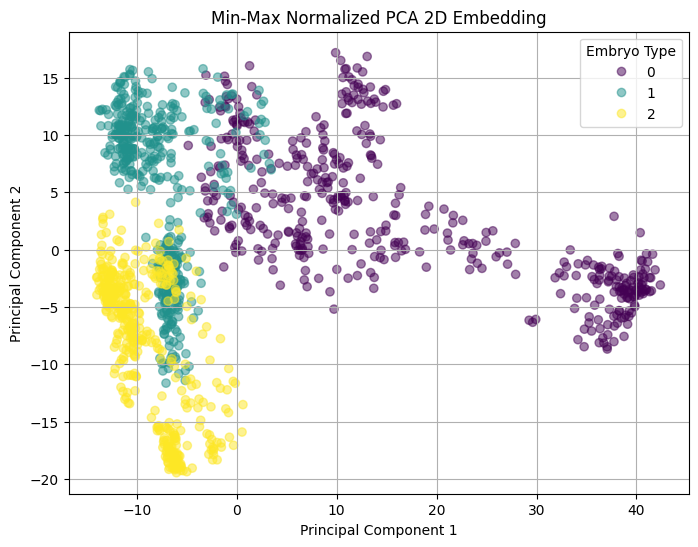

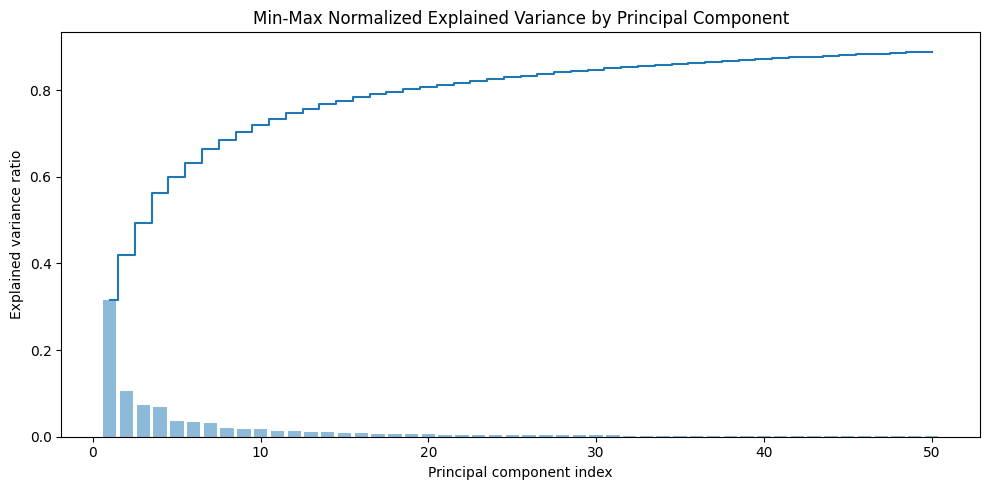


Applying PCA to Standardized Data:


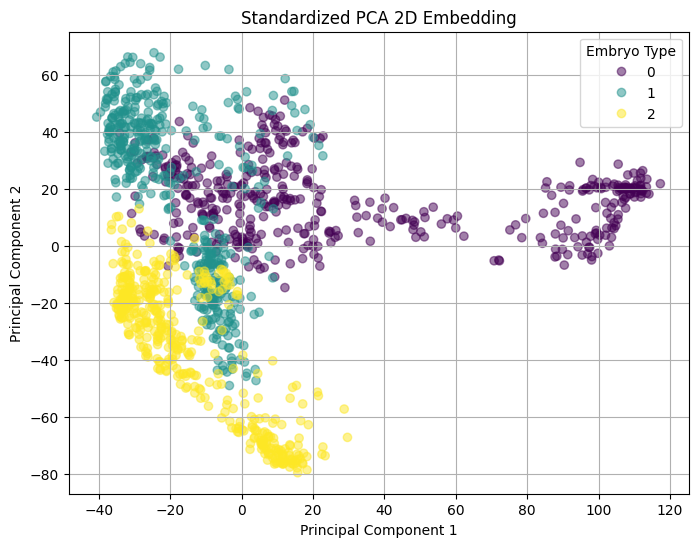

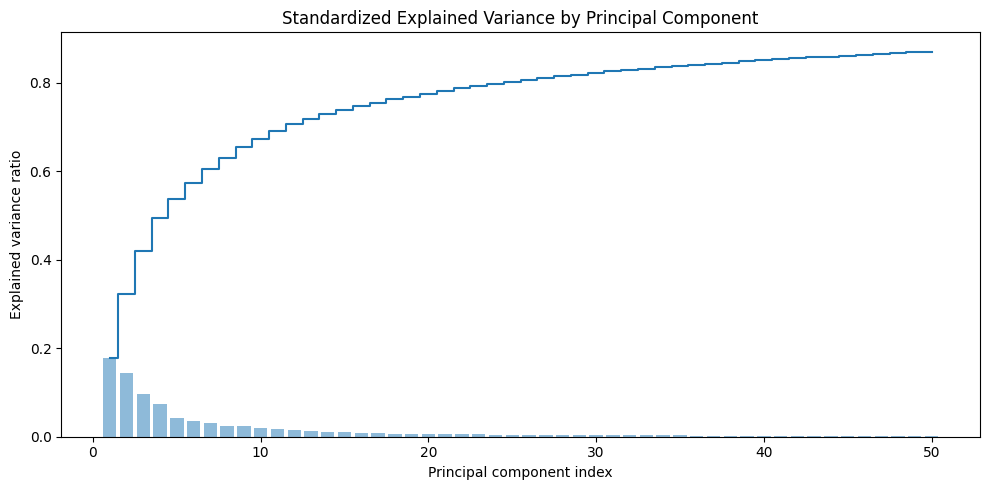

In [ ]:
from sklearn.decomposition import PCA

# Function to perform PCA and plot results
def perform_pca_and_plot(X, labels, title_prefix):
    # PCA for 2D visualization
    pca_2d = PCA(n_components=2)
    X_pca_2d = pca_2d.fit_transform(X)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.title(f'{title_prefix} PCA 2D Embedding')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    legend = plt.legend(*scatter.legend_elements(), title="Embryo Type")
    plt.grid(True)
    plt.show()

    # PCA for explained variance analysis
    pca_variance = PCA(n_components=50)
    pca_variance.fit(X)

    explained_variance_ratio = pca_variance.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center',
            label='Individual explained variance')
    plt.step(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, where='mid',
             label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.title(f'{title_prefix} Explained Variance by Principal Component')
    plt.tight_layout()
    plt.show()

# Apply PCA to Min-Max Normalized data
print("Applying PCA to Min-Max Normalized Data:")
perform_pca_and_plot(X_minmax, labels, 'Min-Max Normalized')

# Apply PCA to Standardized data
print("\nApplying PCA to Standardized Data:")
perform_pca_and_plot(X_standard, labels, 'Standardized')


## SVD (Singular Value Decomposition)

Apply SVD to both datasets and analyze:

The decay of singular values on a log scale.

The cumulative energy of singular values.

Compare how quickly each normalization captures energy.
🔍 Insight: SVD reveals the inherent structure of your dataset. A sharper drop often suggests stronger linear compressibility.

Applying SVD to Min-Max Normalized Data:


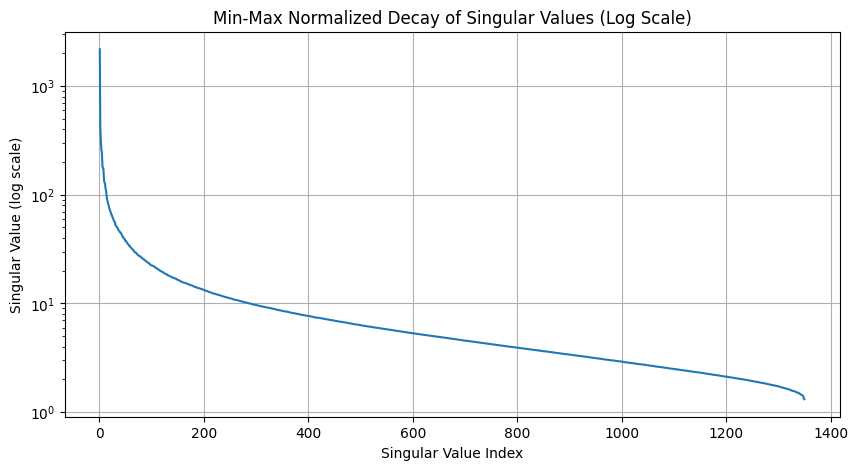

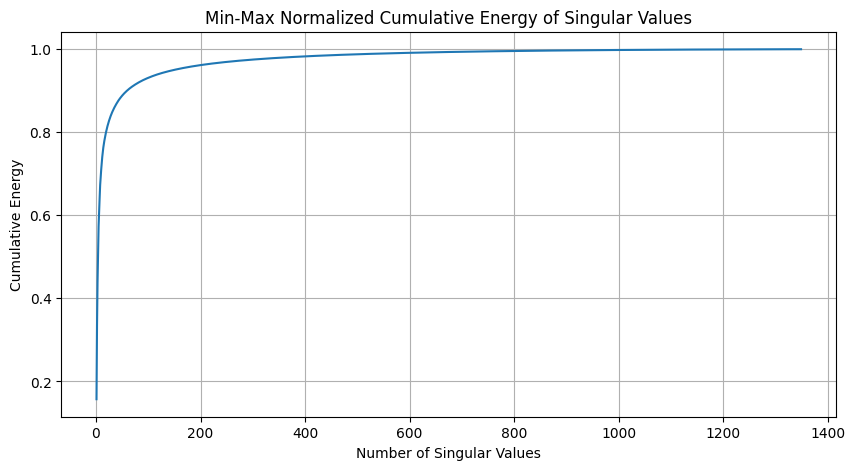


Applying SVD to Standardized Data:


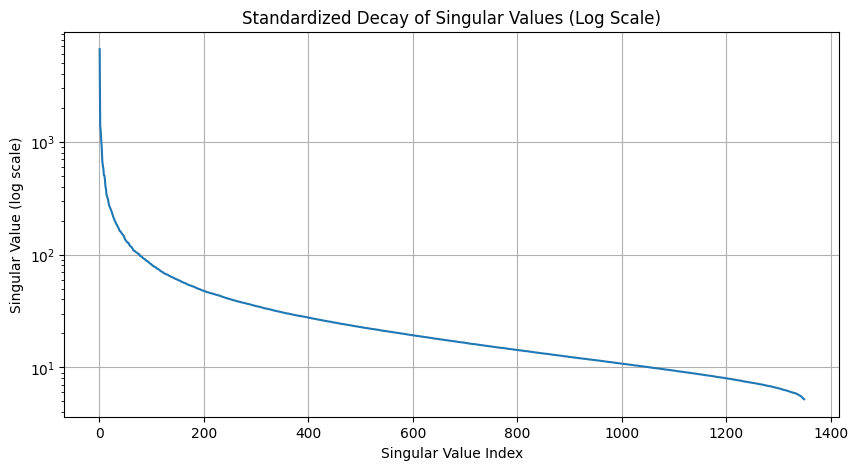

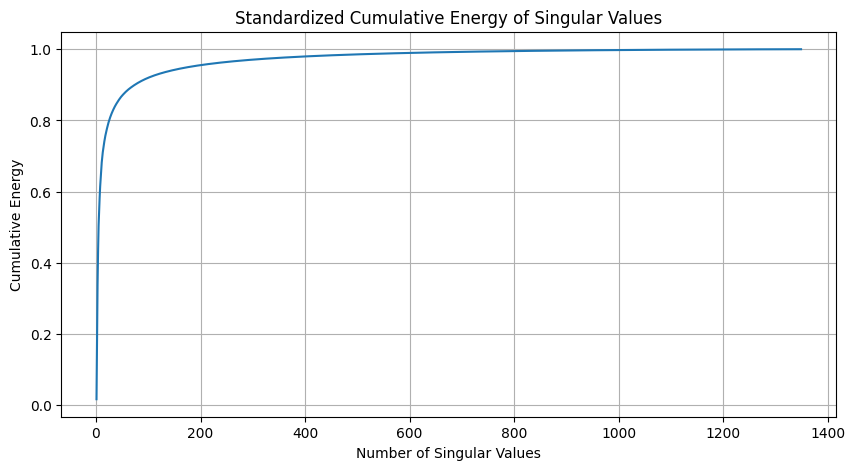

In [ ]:
from sklearn.decomposition import TruncatedSVD

# Function to perform SVD and plot results
def perform_svd_and_plot(X, title_prefix):
    # SVD
    svd = TruncatedSVD(n_components=min(X.shape) - 1)
    svd.fit(X)
    singular_values = svd.singular_values_

    # Plot decay of singular values on a log scale
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(singular_values) + 1), singular_values)
    plt.yscale('log')
    plt.title(f'{title_prefix} Decay of Singular Values (Log Scale)')
    plt.xlabel('Singular Value Index')
    plt.ylabel('Singular Value (log scale)')
    plt.grid(True)
    plt.show()

    # Plot cumulative energy of singular values
    cumulative_energy = svd.explained_variance_ratio_.cumsum()

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(cumulative_energy) + 1), cumulative_energy)
    plt.title(f'{title_prefix} Cumulative Energy of Singular Values')
    plt.xlabel('Number of Singular Values')
    plt.ylabel('Cumulative Energy')
    plt.grid(True)
    plt.show()

# Apply SVD to Min-Max Normalized data
print("Applying SVD to Min-Max Normalized Data:")
perform_svd_and_plot(X_minmax, 'Min-Max Normalized')

# Apply SVD to Standardized data
print("\nApplying SVD to Standardized Data:")
perform_svd_and_plot(X_standard, 'Standardized')

## t-SNE

Use t-SNE to capture local structure and dynamics:

Run t-SNE with different perplexities [5, 30, 100].
Plot the 2D embeddings and analyze how clusters behave.
Compare results between both normalized inputs.
⏳ Note: t-SNE is computationally intensive and sensitive to hyperparameters.

Applying t-SNE to Min-Max Normalized Data:
Applying t-SNE with perplexity=5 to Min-Max Normalized Data...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done! Time elapsed: 10.515981197357178 seconds


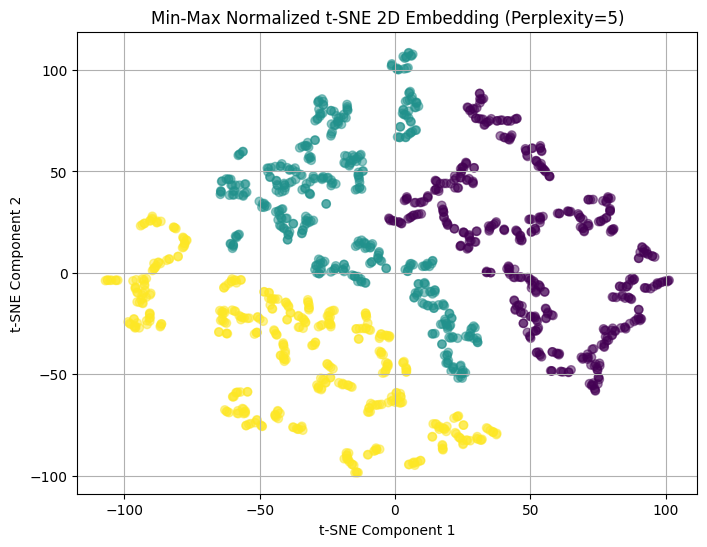

Applying t-SNE with perplexity=30 to Min-Max Normalized Data...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done! Time elapsed: 11.753633260726929 seconds


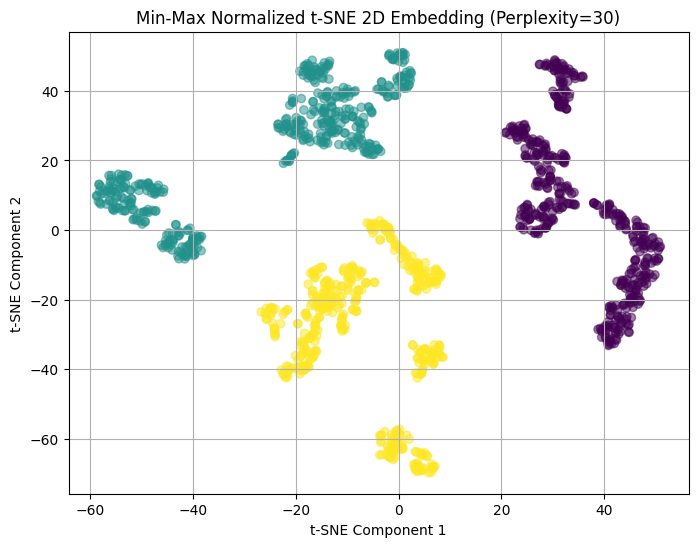

Applying t-SNE with perplexity=100 to Min-Max Normalized Data...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done! Time elapsed: 20.293391466140747 seconds


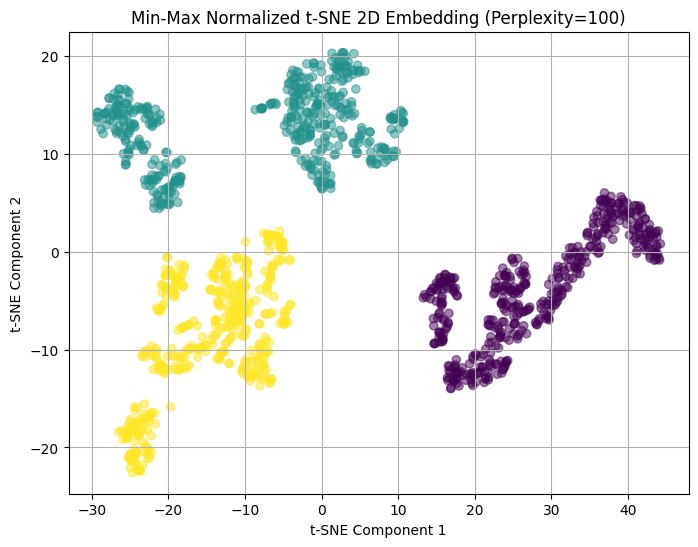


Applying t-SNE to Standardized Data:
Applying t-SNE with perplexity=5 to Standardized Data...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done! Time elapsed: 10.512959241867065 seconds


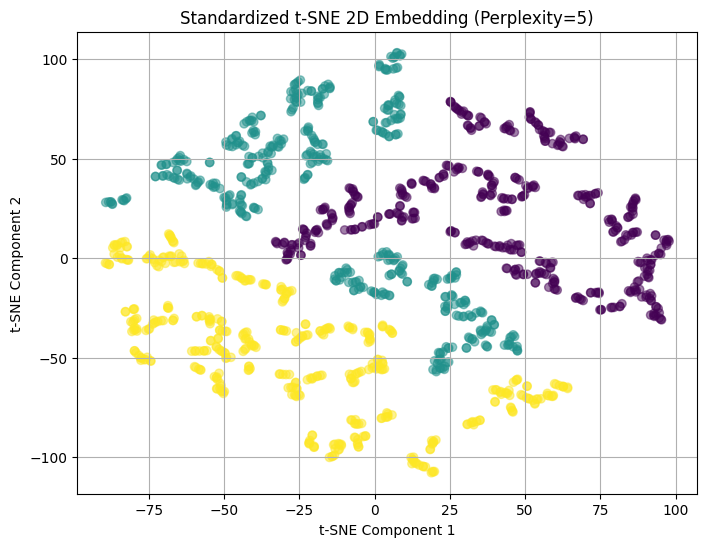

Applying t-SNE with perplexity=30 to Standardized Data...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done! Time elapsed: 11.981717348098755 seconds


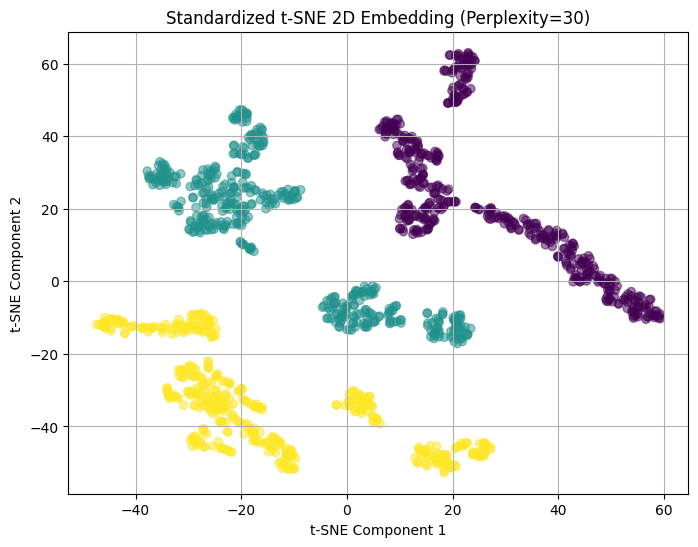

Applying t-SNE with perplexity=100 to Standardized Data...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE done! Time elapsed: 19.016582489013672 seconds


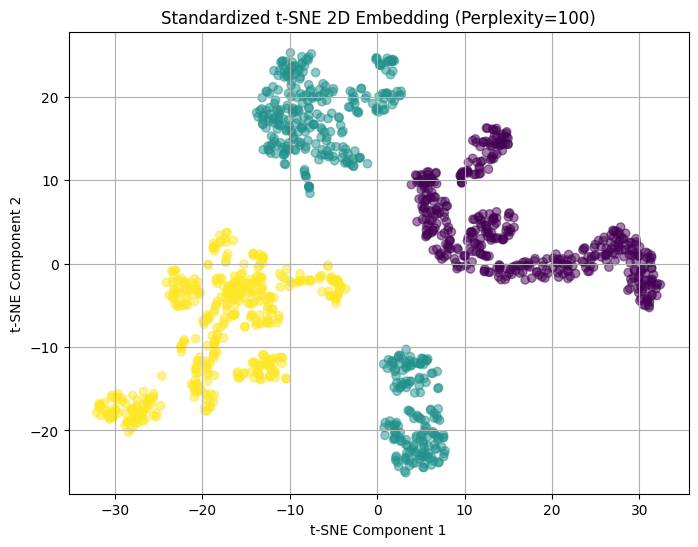

In [ ]:
from sklearn.manifold import TSNE
import time

# Function to perform t-SNE and plot results
def perform_tsne_and_plot(X, labels, title_prefix, perplexities=[5, 30, 100]):
    for perplexity in perplexities:
        print(f"Applying t-SNE with perplexity={perplexity} to {title_prefix} Data...")
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, n_iter=1350)
        time_start = time.time()
        X_tsne = tsne.fit_transform(X)
        print(f"t-SNE done! Time elapsed: {time.time()-time_start} seconds")

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
        plt.title(f'{title_prefix} t-SNE 2D Embedding (Perplexity={perplexity})')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')

        plt.grid(True)
        plt.show()

# Apply t-SNE to Min-Max Normalized data
print("Applying t-SNE to Min-Max Normalized Data:")
perform_tsne_and_plot(X_minmax, labels, 'Min-Max Normalized')

# Apply t-SNE to Standardized data
print("\nApplying t-SNE to Standardized Data:")
perform_tsne_and_plot(X_standard, labels, 'Standardized')

## UMAP

Use UMAP for global structure visualization:

Try combinations of `n_neighbors` and `min_dist`.

Compare embeddings across normalization methods.

Observe both local clustering and trajectory smoothness.

📌 UMAP is faster and often preserves better continuity in developmental trajectories.

Applying UMAP to Min-Max Normalized Data:
Applying UMAP with n_neighbors=15, min_dist=0.1 to Min-Max Normalized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 13.923190593719482 seconds


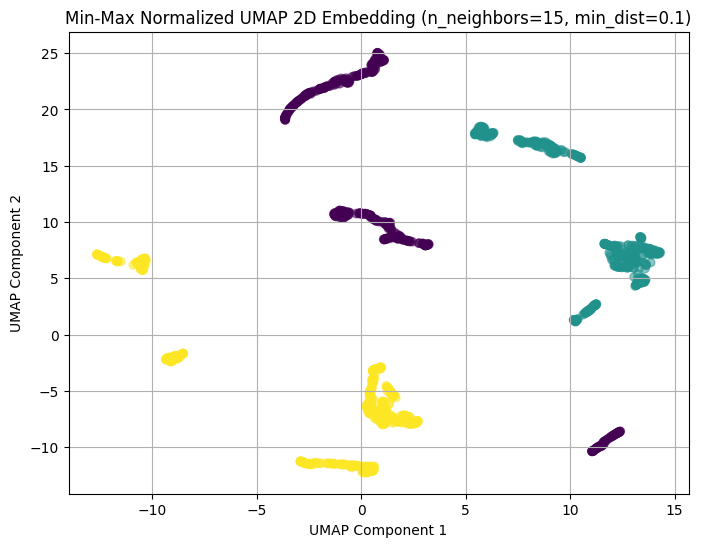

Applying UMAP with n_neighbors=15, min_dist=0.5 to Min-Max Normalized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 12.89797830581665 seconds


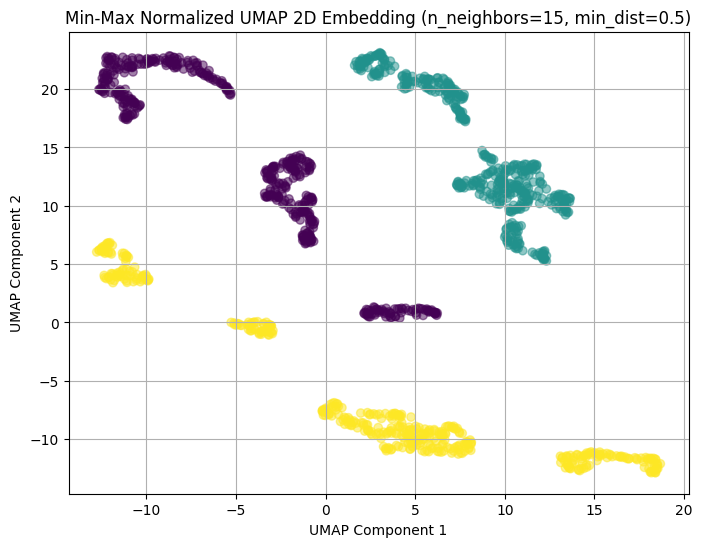

Applying UMAP with n_neighbors=50, min_dist=0.1 to Min-Max Normalized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 14.06939959526062 seconds


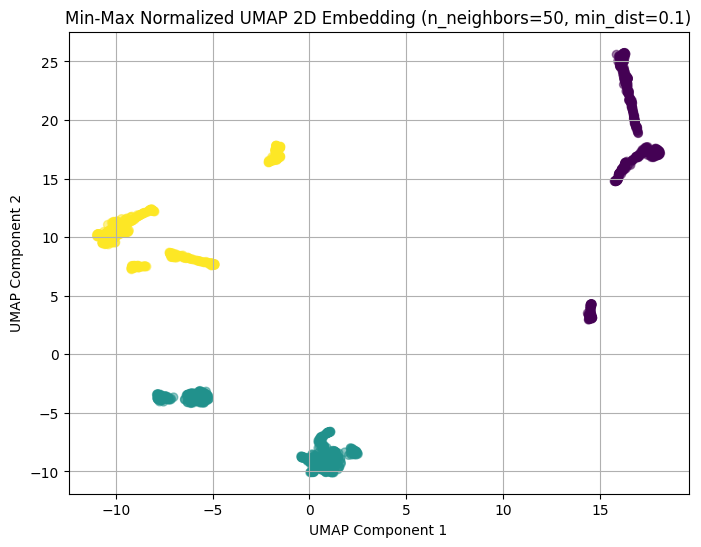

Applying UMAP with n_neighbors=50, min_dist=0.5 to Min-Max Normalized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 16.191632986068726 seconds


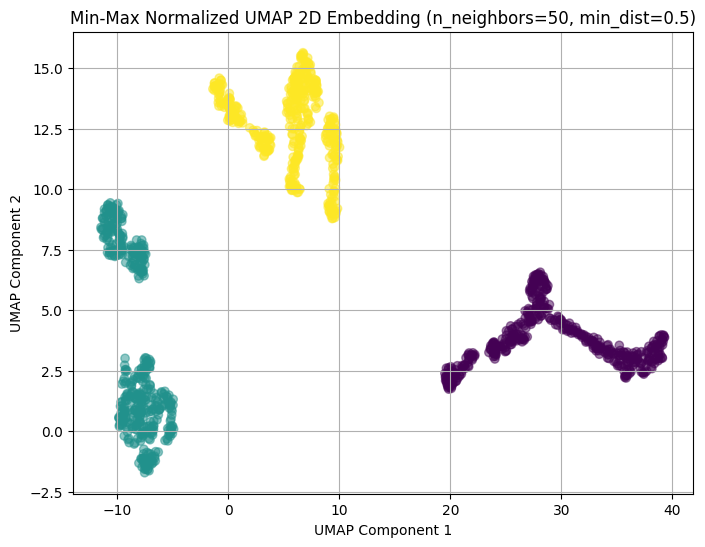


Applying UMAP to Standardized Data:
Applying UMAP with n_neighbors=15, min_dist=0.1 to Standardized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 13.040434122085571 seconds


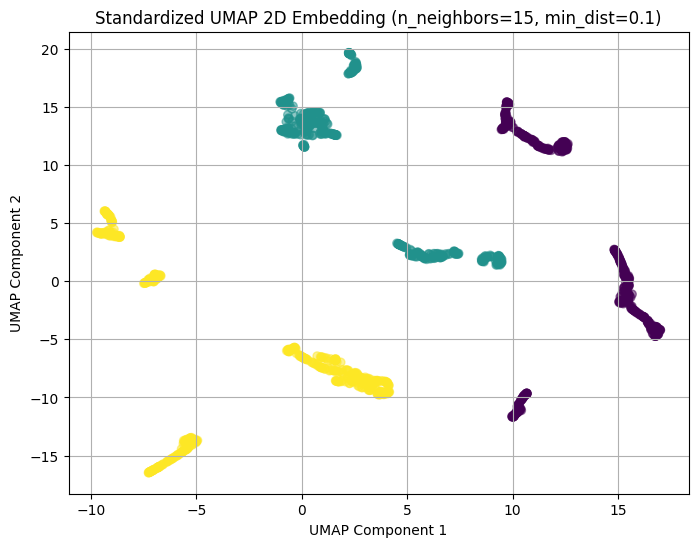

Applying UMAP with n_neighbors=15, min_dist=0.5 to Standardized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 13.076254844665527 seconds


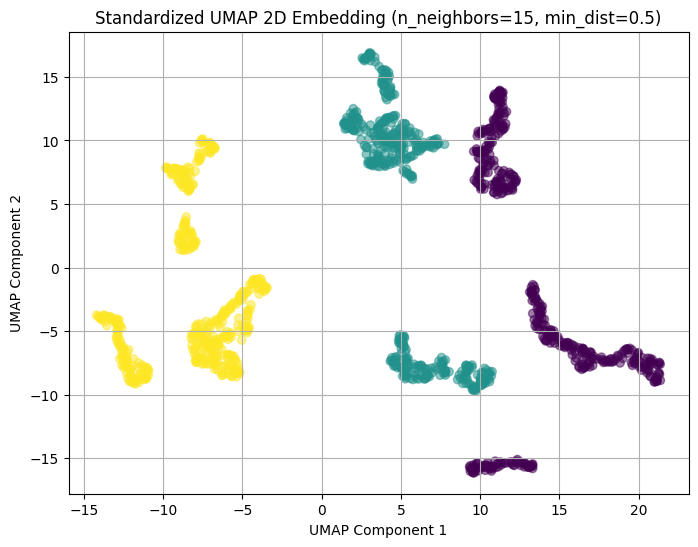

Applying UMAP with n_neighbors=50, min_dist=0.1 to Standardized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 15.526724576950073 seconds


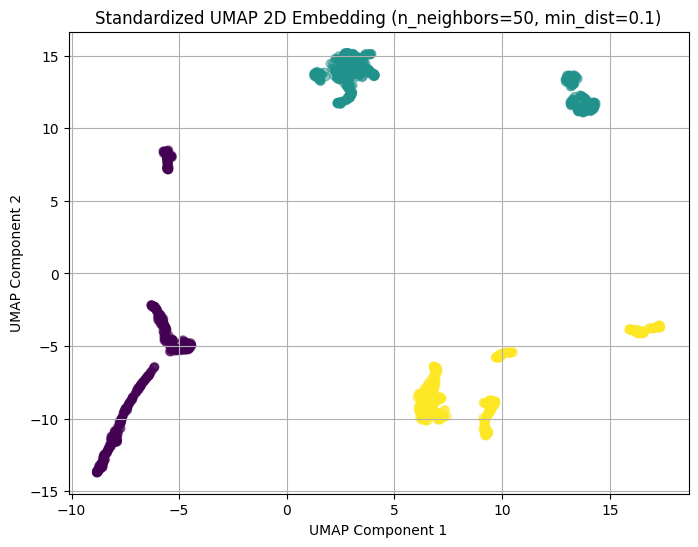

Applying UMAP with n_neighbors=50, min_dist=0.5 to Standardized Data...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done! Time elapsed: 13.780620336532593 seconds


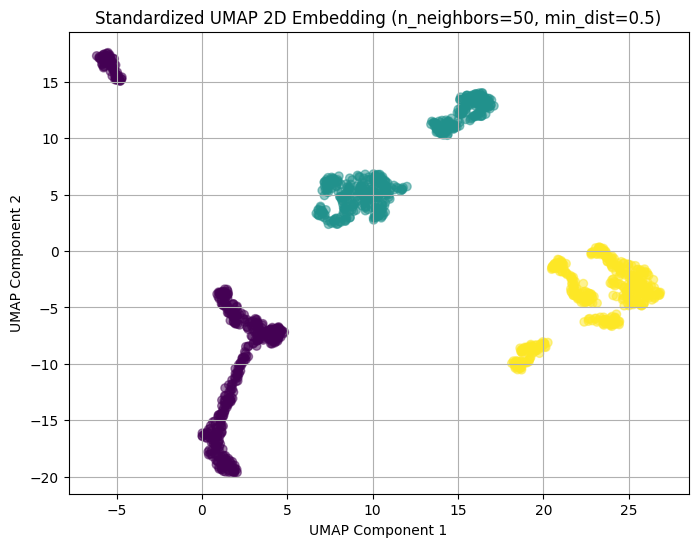

In [ ]:
import umap

# Function to perform UMAP and plot results
def perform_umap_and_plot(X, labels, title_prefix, n_neighbors_list=[15, 50], min_dist_list=[0.1, 0.5]):
    for n_neighbors in n_neighbors_list:
        for min_dist in min_dist_list:
            print(f"Applying UMAP with n_neighbors={n_neighbors}, min_dist={min_dist} to {title_prefix} Data...")
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
            time_start = time.time()
            embedding = reducer.fit_transform(X)
            print(f"UMAP done! Time elapsed: {time.time()-time_start} seconds")

            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='viridis', alpha=0.5)
            plt.title(f'{title_prefix} UMAP 2D Embedding (n_neighbors={n_neighbors}, min_dist={min_dist})')
            plt.xlabel('UMAP Component 1')
            plt.ylabel('UMAP Component 2')
            plt.grid(True)
            plt.show()

# Apply UMAP to Min-Max Normalized data
print("Applying UMAP to Min-Max Normalized Data:")
perform_umap_and_plot(X_minmax, labels, 'Min-Max Normalized')

# Apply UMAP to Standardized data
print("\nApplying UMAP to Standardized Data:")
perform_umap_and_plot(X_standard, labels, 'Standardized')

## Autoencoder

Train a neural autoencoder to learn a 2D latent space:

Architecture: input → 128 → 32 → 2 → 32 → 128 → output
Use ReLU activations and MSE loss.
Plot the latent 2D representations colored by embryo.
💡 Autoencoders are flexible nonlinear methods that may capture dynamics not seen by linear projections.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 40000)          │     5,160,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,288,642 (39.25 MB)

 Trainable params: 10,288,642 (39.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - loss: 0.1936 - val_loss: 0.1347
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.0876 - val_loss: 0.0274
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - loss: 0.0258 - val_loss: 0.0192
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - loss: 0.0234 - val_loss: 0.0212
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - loss: 0.0223 - val_loss: 0.0181
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - loss: 0.0215 - val_loss: 0.0186
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - loss: 0.0208 - val_loss: 0.0176
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 286ms/step - loss: 0.0208 - val_loss: 0.0171
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.0198 - val_loss: 0.0182
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - loss: 0.0196 - val_loss: 0.0171
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - loss: 0.0198 - val_loss: 0.0163
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - loss: 0.0

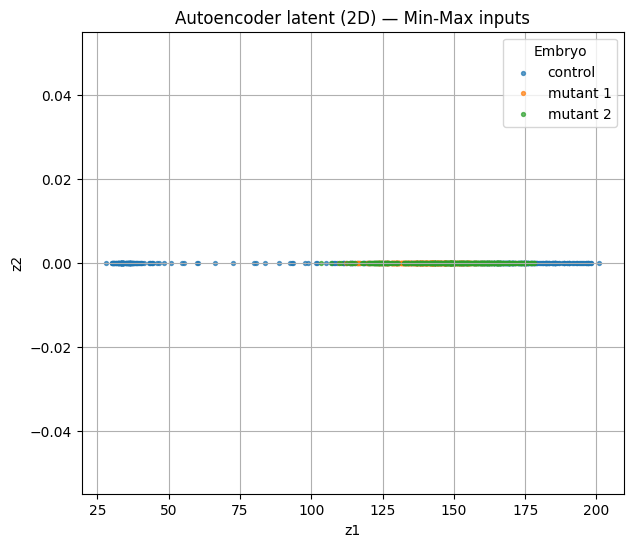

In [ ]:
##MinMax Normalized Data

# Define the autoencoder model
input_dim_minmax = X_minmax.shape[1] # Input dimension is the number of pixels

# Encoder
input_layer = Input(shape=(input_dim_minmax,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
latent_representation = Dense(2, activation='relu')(encoded) # 2D latent space

# Decoder
decoded = Dense(32, activation='relu')(latent_representation)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim_minmax, activation='sigmoid')(decoded) # Output layer with sigmoid for [0,1] reconstruction

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Encoder model (for extracting latent representations)
encoder = Model(inputs=input_layer, outputs=latent_representation)

autoencoder.summary()

# Compile: MSE loss is standard for autoencoders
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

# Fit: reconstruct X_minmax from X_minmax
history = autoencoder.fit(
    X_minmax, X_minmax,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

# Get 2D latent embedding
Z = encoder.predict(X_minmax, batch_size=512, verbose=0)

# Plot latent colored by embryo label
names = {0:'control', 1:'mutant 1', 2:'mutant 2'}
import numpy as np
plt.figure(figsize=(7,6))
for c in np.unique(labels):
    m = (labels == c)
    plt.scatter(Z[m,0], Z[m,1], s=8, alpha=0.7, label=names.get(c, str(c)))
plt.title('Autoencoder latent (2D) — Min-Max inputs')
plt.xlabel('z1'); plt.ylabel('z2'); plt.legend(title='Embryo'); plt.grid(True); plt.show()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 2)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 40000)          │     5,160,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,288,642 (39.25 MB)

 Trainable params: 10,288,642 (39.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 307ms/step - loss: 0.8975 - val_loss: 0.3137
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - loss: 0.3099 - val_loss: 0.4189
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - loss: 0.3159 - val_loss: 0.2729
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 0.2296 - val_loss: 0.2697
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step - loss: 0.2249 - val_loss: 0.2546
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 0.2072 - val_loss: 0.2580
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - loss: 0.2026 - val_loss: 0.2409
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 370ms/step - loss: 0.1961 - val_loss: 0.2407
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - loss: 0.1988 - val_loss: 0.2451
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.1941 - val_loss: 0.2426
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - loss: 0.1939 - val_loss: 0.2386
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - loss: 0.1

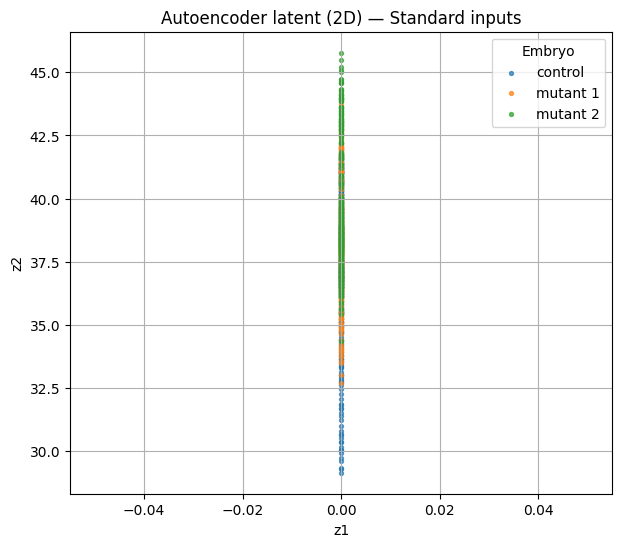

In [ ]:
##Standard Data

# Define the autoencoder model
input_dim_stan = X_standard.shape[1] # Input dimension is the number of pixels

# Encoder
input_layer = Input(shape=(input_dim_stan,))
encoded = Dense(128, activation='relu')(input_layer)
encoded = Dense(32, activation='relu')(encoded)
latent_representation = Dense(2, activation='relu')(encoded) # 2D latent space

# Decoder
decoded = Dense(32, activation='relu')(latent_representation)
decoded = Dense(128, activation='relu')(decoded)
output_layer = Dense(input_dim_stan, activation='linear')(decoded) # Output layer with sigmoid for [0,1] reconstruction

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Encoder model (for extracting latent representations)
encoder = Model(inputs=input_layer, outputs=latent_representation)

autoencoder.summary()

# Compile: MSE loss is standard for autoencoders
autoencoder.compile(optimizer=Adam(1e-3), loss='mse')

# Fit: reconstruct X_standar from X_standard
history = autoencoder.fit(
    X_standard, X_standard,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

# Get 2D latent embedding
Z = encoder.predict(X_standard, batch_size=512, verbose=0)

# Plot latent colored by embryo label
names = {0:'control', 1:'mutant 1', 2:'mutant 2'}
import numpy as np
plt.figure(figsize=(7,6))
for c in np.unique(labels):
    m = (labels == c)
    plt.scatter(Z[m,0], Z[m,1], s=8, alpha=0.7, label=names.get(c, str(c)))
plt.title('Autoencoder latent (2D) — Standard inputs')
plt.xlabel('z1'); plt.ylabel('z2'); plt.legend(title='Embryo'); plt.grid(True); plt.show()

##Final Reflection
1.	What differences in developmental dynamics did you observe?

Each embryo type follows a distinct, smooth trajectory rather than a single blob—visible in PCA, t-SNE (p=5/30), and UMAP (especially with smaller n_neighbors and higher min_dist).

Control shows a long, monotonic progression (PCA: strong drift along PC1; UMAP/t-SNE: an extended arc).

Mutant 1 vs Mutant 2 take different paths: one trends “up/left,” the other “down/left” in PCA; in UMAP/t-SNE each forms its own ribbon with minimal overlap either with control or with each other.

SVD confirms the structure is moderately low-rank: a steep head then long tail; ~85–90% variance by ~50–100 comps, consistent with the PCA EVR curves.

2. Which method best captured biologically relevant features?

UMAP gave the clearest combination of class separation and trajectory continuity.

With Standardized inputs, n_neighbors=15–50 and min_dist=0.5 preserved smooth within-embryo progress while keeping embryos well separated.

t-SNE separated classes strongly at higher perplexity (p=100) but fragmented trajectories.

PCA clearly revealed global axes (PC1 ≈ time; PC2 ≈ mutant-specific changes) and provided interpretability + variance diagnostics.

So, UMAP (Standardized) best reflected the developmental manifolds; PCA provided interpretable axes; t-SNE corroborated clusters but was more parameter-sensitive; the current Autoencoder setup didn’t help.

3. Which normalization (Min-Max or StandardScaler) led to better embeddings?

Standardization was consistently better.

PCA: cleaner, more orthogonal separation; mutants more distinct from each other.

t-SNE: more stable layouts across perplexities and smoother ribbons.

UMAP: clearer mutant-vs-mutant separation and trajectory continuity across hyperparameters.

SVD/EVR curves were very similar across normalizations (so rank/compressibility is similar).

4. At which point do mutant trajectories diverge from normal?

We can see that qualitatively early in the time course.

In PCA, the control’s early path along PC1 is already offset from both mutants along PC2, with little overlap.

In t-SNE (p=30) and UMAP (e.g., Standardized, n_neighbors=15, min_dist=0.5), the initial segments of the mutant ribbons are already displaced from the control ribbon.

Within the first ~10–20% of frames the mutants have branched from the control manifold.

5. How consistent were the results across methods?

All methods agree on three distinct manifolds and a monotonic control trajectory.

SVD/PCA say the data are compressible (few dozen comps capture most variance), supporting PCA→50 as a good pre-step.

UMAP: best trade-off of separation + continuity; relatively robust to parameter changes.

t-SNE: strong separation; continuity depends heavily on perplexity (lower = smoother, higher = more compact islands).

PCA: linear, interpretable axes; good global structure but less detail on curved manifolds.

Autoencoder: with the current ReLU-2D bottleneck + MSE, it collapsed and did not add information.


